# LSTM

## [1] 데이터 로딩
---

In [7]:
# 모듈 로딩
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

mpl.rc('font',family='Malgun Gothic')

In [8]:
# data ,target 데이터 불러오기
data = pd.read_csv('./data_final.csv',index_col=0)
target = pd.read_csv('./target.csv')

# 민수용, 산업용
target_c = target['CIVIL']
target_i = target['IND']

# 제공 데이터 추가
data_Qva = pd.read_csv('./Data_Qva.csv') # 제조업부가가치(분기별) -> 4배 해줘야 함
data_RV = pd.read_csv('./Data_RV.csv') # 상대지수

### 데이터 형식 통합 

In [9]:
#### 1.제조업 부가가치: data_QVA ####
# 연도별 4분기 데이터(4개월)를 연도별 12개월로 복제 생성

data_QVA_final= pd.DataFrame()
for i in range(100):
    quarter = pd.concat([(data_Qva.iloc[i:i+1]),(data_Qva.iloc[i:i+1]),(data_Qva.iloc[i:i+1])], ignore_index = True)
    data_QVA_final = pd.concat([data_QVA_final,quarter])

# 인덱스 초기화
data_QVA_final = data_QVA_final.reset_index()
# 불필요한 컬럼 삭제
data_QVA_final = data_QVA_final.drop(['YEAR','index'],axis=1)

In [10]:
data_RV

,DATE,RV,GAS_PRICE_IND,OIL_PRICE
0,1996-01-01,0.97,26.94,27.86
1,1996-02-01,0.93,26.94,29.04
2,1996-03-01,0.96,26.94,27.99
3,1996-04-01,0.94,26.94,28.74
4,1996-05-01,0.92,26.94,29.18
...,...,...,...,...
295,2020-08-01,0.86,72.93,84.71
296,2020-09-01,0.80,65.24,81.26
297,2020-10-01,0.76,59.16,78.13
298,2020-11-01,0.75,58.72,78.64


In [11]:
#### 2.상대지수 : data_RV ####

# 필요없는 컬럼 삭제
data_RV = data_RV.drop(['DATE'],axis=1)
data_RV

,RV,GAS_PRICE_IND,OIL_PRICE
0,0.97,26.94,27.86
1,0.93,26.94,29.04
2,0.96,26.94,27.99
3,0.94,26.94,28.74
4,0.92,26.94,29.18
...,...,...,...
295,0.86,72.93,84.71
296,0.80,65.24,81.26
297,0.76,59.16,78.13
298,0.75,58.72,78.64


In [12]:
data = pd.concat([data,data_QVA_final,data_RV],axis=1)

In [13]:
data

,YEAR,AT,LT,HT,CAP_TEMP_EF,DONGNAM_TEMP_EF,DAEGYUNG_TEMP_EF,CHOONG_TEMP_EF,HONAM_TEMP_EF,MEAN_TEMP_EF,...,civil_sum,argri_fishing,mining,manufact,ind_sum,QUARTER,Value,RV,GAS_PRICE_IND,OIL_PRICE
0,1996-01-01,0.004764,-0.189311,0.240528,0.84711,5.91778,6.73765,3.33479,1.88651,3.744768,...,6988059,301811,80421,8854576,9236808,Q1,36550.3,0.97,26.94,27.86
1,1996-02-01,0.007708,-0.226982,0.372691,0.81430,5.90875,6.73291,3.32638,1.87883,3.732234,...,6898533,327617,70471,8067220,8465308,Q1,36550.3,0.93,26.94,29.04
2,1996-03-01,0.137972,-0.045631,0.367739,0.60731,5.81529,6.67634,3.22000,1.78740,3.621268,...,6416945,345359,81877,9250086,9677322,Q1,36550.3,0.96,26.94,27.99
3,1996-04-01,0.261910,0.029456,0.582132,0.24132,5.71003,6.61264,3.07795,1.66054,3.460496,...,6615182,292235,84596,9274014,9650845,Q2,37152.4,0.94,26.94,28.74
4,1996-05-01,0.428759,0.242892,0.688458,-0.38328,5.67433,6.58956,3.02586,1.62083,3.305460,...,6370027,302913,80963,9274169,9658045,Q2,37152.4,0.92,26.94,29.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2020-08-01,3.341732,3.072238,3.949415,-0.52038,5.55479,6.50341,2.91789,1.55535,3.202212,...,22252059,1432700,110871,20803586,22347157,Q3,121747.5,0.86,72.93,84.71
296,2020-09-01,2.623888,2.040712,3.317034,-0.48046,5.62159,6.57738,2.98076,1.59811,3.259476,...,22125819,1535383,124192,21325400,22984975,Q3,121747.5,0.80,65.24,81.26
297,2020-10-01,1.844505,1.092630,2.554311,-0.14824,5.67245,6.61732,3.06704,1.64228,3.370170,...,17725942,1164339,121749,20053280,21339368,Q4,124740.4,0.76,59.16,78.13
298,2020-11-01,1.149119,0.389722,2.114493,0.23138,5.73286,6.65465,3.15240,1.70088,3.494434,...,18720765,1580276,156931,20689055,22426262,Q4,124740.4,0.75,58.72,78.64


In [14]:
# object type : 분기 데이터(분류 데이터) -> 라벨 인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['QUARTER'] = le.fit_transform(data['QUARTER'])

In [15]:
# to_csv
data.to_csv('./data_m.csv',index = False)

## [2] 데이터 시각화
---

Text(0, 0.5, 'gas')

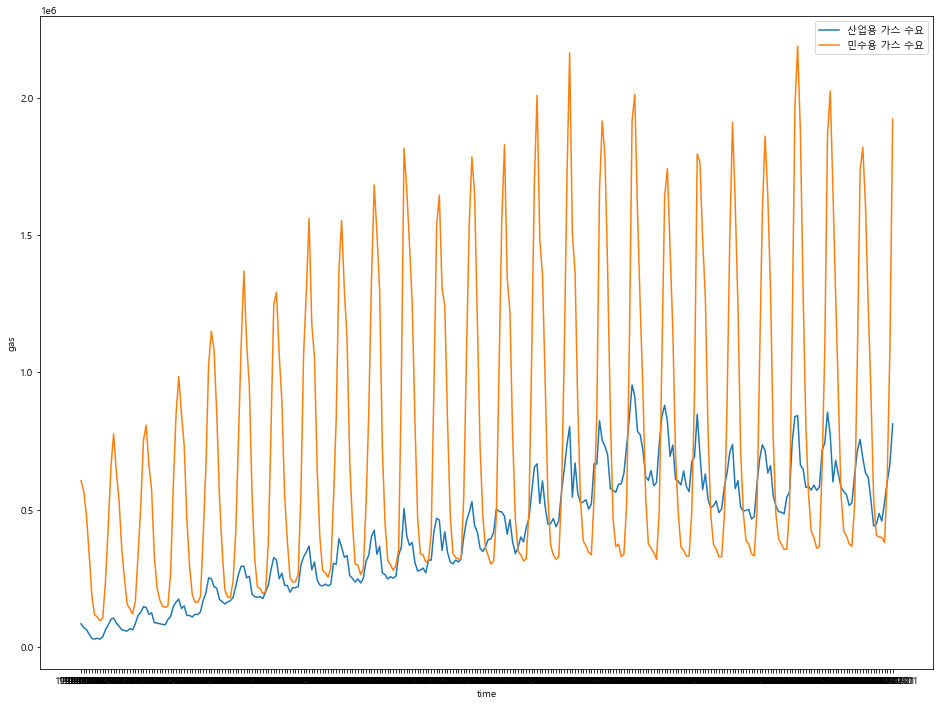

In [16]:
plt.figure(figsize=(16, 12))
sns.lineplot(y=target['IND'], x=data['YEAR'], label='산업용 가스 수요')
sns.lineplot(y=target['CIVIL'], x=data['YEAR'], label ='민수용 가스 수요')
plt.legend()
plt.xlabel('time')
plt.ylabel('gas')

## [3] 데이터 전처리
---

#### 스케일링

In [17]:
data.iloc[:,1:].columns

Index(['AT', 'LT', 'HT', 'CAP_TEMP_EF', 'DONGNAM_TEMP_EF', 'DAEGYUNG_TEMP_EF',
       'CHOONG_TEMP_EF', 'HONAM_TEMP_EF', 'MEAN_TEMP_EF', 'POWER_WATER',
       'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON', 'POWER_GROUP',
       'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO', 'POWER_YOU',
       'POWER_LNG', 'all', 'family', 'public', 'service', 'civil_sum',
       'argri_fishing', 'mining', 'manufact', 'ind_sum', 'QUARTER', 'Value',
       'RV', 'GAS_PRICE_IND', 'OIL_PRICE'],
      dtype='object')

In [18]:
# 컬럼 구성

In [19]:
# 데이터 정규화
from sklearn.preprocessing import MinMaxScaler

#data.sort_index(ascending=False).reset_index(drop=True)

data_col = ['AT', 'LT', 'HT', 'CAP_TEMP_EF', 'DONGNAM_TEMP_EF', 'DAEGYUNG_TEMP_EF',
       'CHOONG_TEMP_EF', 'HONAM_TEMP_EF', 'MEAN_TEMP_EF', 'POWER_WATER',
       'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON', 'POWER_GROUP',
       'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO', 'POWER_YOU',
       'POWER_LNG', 'all', 'family', 'public', 'service', 'civil_sum',
       'argri_fishing', 'mining', 'manufact', 'ind_sum', 'Value',
       'RV', 'GAS', 'OTHER OIL PRODUCT','QUARTER']

scaler = MinMaxScaler()

data_scaled = scaler.fit_transform(data.iloc[:,1:]) # YEAR 제외
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = data_col

data_scaled


,AT,LT,HT,CAP_TEMP_EF,DONGNAM_TEMP_EF,DAEGYUNG_TEMP_EF,CHOONG_TEMP_EF,HONAM_TEMP_EF,MEAN_TEMP_EF,POWER_WATER,...,civil_sum,argri_fishing,mining,manufact,ind_sum,Value,RV,GAS,OTHER OIL PRODUCT,QUARTER
0,0.119401,0.211867,0.059217,0.962362,0.843924,0.842862,0.836159,0.803336,0.897574,0.165935,...,0.032655,0.008191,0.089819,0.057683,0.049688,0.000000,0.009127,0.576471,0.000000,0.000000
1,0.120178,0.202764,0.092605,0.944191,0.823706,0.826438,0.819845,0.785243,0.879284,0.159738,...,0.027925,0.024838,0.038433,0.005028,0.002813,0.000000,0.009127,0.529412,0.000000,0.006917
2,0.154554,0.246586,0.091354,0.829553,0.614455,0.630423,0.613482,0.569850,0.717359,0.165656,...,0.002479,0.036284,0.097338,0.084134,0.076453,0.000000,0.009127,0.564706,0.000000,0.000762
3,0.187260,0.264731,0.145515,0.626857,0.378784,0.409702,0.337924,0.270990,0.482756,0.169633,...,0.012953,0.002014,0.111380,0.085734,0.074844,0.333333,0.015879,0.541176,0.000000,0.005159
4,0.231290,0.316306,0.172376,0.280936,0.298854,0.329730,0.236877,0.177441,0.256523,0.235305,...,0.000000,0.008902,0.092618,0.085744,0.075281,0.333333,0.015879,0.517647,0.000000,0.007738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.000000,1.000000,0.996179,0.205006,0.031211,0.031220,0.027430,0.023181,0.105861,0.803492,...,0.839172,0.737714,0.247074,0.856790,0.846251,0.666667,0.964534,0.447059,0.436960,0.333255
296,0.810567,0.750738,0.836423,0.227114,0.180772,0.287526,0.149389,0.123916,0.189422,0.629421,...,0.832501,0.803953,0.315869,0.891687,0.885004,0.666667,0.964534,0.376471,0.363895,0.313031
297,0.604894,0.521640,0.643739,0.411108,0.294644,0.425918,0.316760,0.227973,0.350950,0.265176,...,0.600022,0.564597,0.303253,0.806613,0.785020,1.000000,0.998097,0.329412,0.306128,0.294683
298,0.421387,0.351787,0.532630,0.621352,0.429899,0.555267,0.482347,0.366024,0.532280,0.221027,...,0.652586,0.832913,0.484946,0.849131,0.851057,1.000000,0.998097,0.317647,0.301948,0.297673


## [4] 데이터셋 분리
---

In [20]:
# 과거 데이터 학습 함수
def make_dataset(data, label, window_size=12):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size): # 데이터 개월 개수 - 학습할 과거개월수 
        feature_list.append(np.array(data.iloc[i:i+window_size])) # 시작 개월 ~ 12개월
        label_list.append(np.array(label.iloc[i+window_size])) # 12개월 후 타겟 데이터
    return np.array(feature_list), np.array(label_list)

In [21]:
# train, test 범위 설정

TEST_SIZE = 60 # 테스트: 2020년(12개월) / 학습: 1996~2019(288개월)
WINDOW_SIZE = 12 # 학습시킬 과거 개월 단위(12개월)

x_train = data_scaled[:-TEST_SIZE] # 1996~2014
x_test = data_scaled[-TEST_SIZE:] # 2015~2020

y_train = target_c[:-TEST_SIZE]
y_test = target_c[-TEST_SIZE:]

In [22]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((240, 34), (60, 34), (240,), (60,))

In [23]:
# train, test, valid / target 분리
from sklearn.model_selection import train_test_split

# 과거 12개월-> 다음 1개월 예측( 1996~2014년 ) 
train_feature, train_label = make_dataset(x_train, y_train, 12)
x_test, y_test = make_dataset(x_test, y_test, 12)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((182, 12, 34), (46, 12, 34))

In [24]:
# (학습할 개월 수,과거학습단위, 컬럼수)
train_feature.shape, train_label.shape 

((228, 12, 34), (228,))

In [25]:
x_test.shape, y_test.shape

((48, 12, 34), (48,))

In [26]:
x_test.shape, y_test.shape

((48, 12, 34), (48,))

## [5] 모형 학습
---

In [27]:
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [28]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

#model_path = 'model'
#filename = os.path.join(model_path, 'tmp_checkpoint.h5')
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid),
                                    callbacks=[early_stop])

Epoch 1/200
12/12 [==============================] - 1s 24ms/step - loss: 863718014976.0000 - val_loss: 648936488960.0000
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 863713951744.0000 - val_loss: 648929935360.0000
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 863686950912.0000 - val_loss: 648863350784.0000
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 863403442176.0000 - val_loss: 648257863680.0000
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 861267165184.0000 - val_loss: 643405316096.0000
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 841687105536.0000 - val_loss: 608140853248.0000
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 743935246336.0000 - val_loss: 457252077568.0000
Epoch 8/200
12/12 [==============================] - 0s 5ms/step - loss: 406995337216.0000 - val_loss: 154835681280.0000
Epoch 9/200
12/12 [============

## test 예측
---

In [29]:
pred = model.predict(x_test)
pred.shape

2/2 [==============================] - 0s 2ms/step


(48, 1)

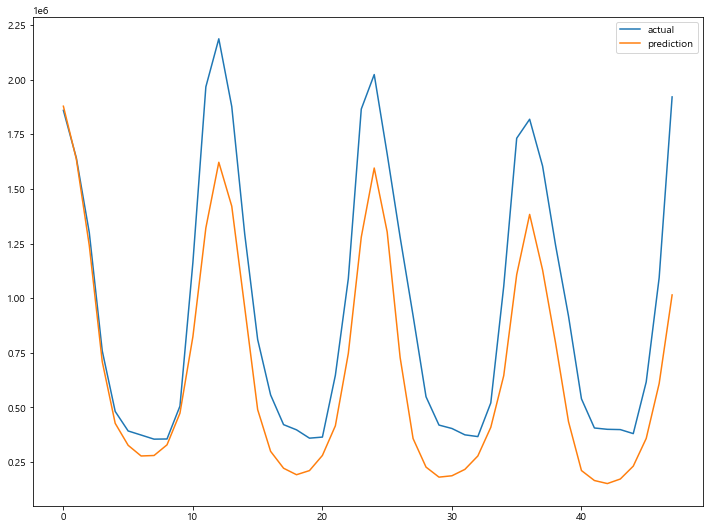

In [30]:
plt.figure(figsize=(12, 9))
#plt.plot(target_i, label = 'total_actual')
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

## 타겟까지 스케일링해서 모델링
---

In [31]:
# df 생성
df = pd.concat([data,target_c,target_i], axis=1)

In [32]:
df.columns

Index(['YEAR', 'AT', 'LT', 'HT', 'CAP_TEMP_EF', 'DONGNAM_TEMP_EF',
       'DAEGYUNG_TEMP_EF', 'CHOONG_TEMP_EF', 'HONAM_TEMP_EF', 'MEAN_TEMP_EF',
       'POWER_WATER', 'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON',
       'POWER_GROUP', 'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO',
       'POWER_YOU', 'POWER_LNG', 'all', 'family', 'public', 'service',
       'civil_sum', 'argri_fishing', 'mining', 'manufact', 'ind_sum',
       'QUARTER', 'Value', 'RV', 'GAS_PRICE_IND', 'OIL_PRICE', 'CIVIL', 'IND'],
      dtype='object')

In [34]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['AT', 'LT', 'HT', 'CAP_TEMP_EF', 'DONGNAM_TEMP_EF',
       'DAEGYUNG_TEMP_EF', 'CHOONG_TEMP_EF', 'HONAM_TEMP_EF', 'MEAN_TEMP_EF',
       'POWER_WATER', 'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON',
       'POWER_GROUP', 'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO',
       'POWER_YOU', 'POWER_LNG', 'all', 'family', 'public', 'service',
       'civil_sum', 'argri_fishing', 'mining', 'manufact', 'ind_sum',
       'QUARTER', 'Value', 'RV', 'GAS_PRICE_IND', 'OIL_PRICE','CIVIL','IND']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,AT,LT,HT,CAP_TEMP_EF,DONGNAM_TEMP_EF,DAEGYUNG_TEMP_EF,CHOONG_TEMP_EF,HONAM_TEMP_EF,MEAN_TEMP_EF,POWER_WATER,...,mining,manufact,ind_sum,QUARTER,Value,RV,GAS_PRICE_IND,OIL_PRICE,CIVIL,IND
0,0.119401,0.211867,0.059217,0.962362,0.843924,0.842862,0.836159,0.803336,0.897574,0.165935,...,0.089819,0.057683,0.049688,0.000000,0.009127,0.576471,0.000000,0.000000,0.244088,0.060116
1,0.120178,0.202764,0.092605,0.944191,0.823706,0.826438,0.819845,0.785243,0.879284,0.159738,...,0.038433,0.005028,0.002813,0.000000,0.009127,0.529412,0.000000,0.006917,0.225357,0.045653
2,0.154554,0.246586,0.091354,0.829553,0.614455,0.630423,0.613482,0.569850,0.717359,0.165656,...,0.097338,0.084134,0.076453,0.000000,0.009127,0.564706,0.000000,0.000762,0.182918,0.037249
3,0.187260,0.264731,0.145515,0.626857,0.378784,0.409702,0.337924,0.270990,0.482756,0.169633,...,0.111380,0.085734,0.074844,0.333333,0.015879,0.541176,0.000000,0.005159,0.116152,0.020386
4,0.231290,0.316306,0.172376,0.280936,0.298854,0.329730,0.236877,0.177441,0.256523,0.235305,...,0.092618,0.085744,0.075281,0.333333,0.015879,0.517647,0.000000,0.007738,0.042906,0.002725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.000000,1.000000,0.996179,0.205006,0.031211,0.031220,0.027430,0.023181,0.105861,0.803492,...,0.247074,0.856790,0.846251,0.666667,0.964534,0.447059,0.436960,0.333255,0.145237,0.464516
296,0.810567,0.750738,0.836423,0.227114,0.180772,0.287526,0.149389,0.123916,0.189422,0.629421,...,0.315869,0.891687,0.885004,0.666667,0.964534,0.376471,0.363895,0.313031,0.136431,0.537632
297,0.604894,0.521640,0.643739,0.411108,0.294644,0.425918,0.316760,0.227973,0.350950,0.265176,...,0.303253,0.806613,0.785020,1.000000,0.998097,0.329412,0.306128,0.294683,0.249422,0.618987
298,0.421387,0.351787,0.532630,0.621352,0.429899,0.555267,0.482347,0.366024,0.532280,0.221027,...,0.484946,0.849131,0.851057,1.000000,0.998097,0.317647,0.301948,0.297673,0.477397,0.689252


In [35]:
TEST_SIZE = 36
WINDOW_SIZE = 6

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [36]:
def make_dataset(data, label, window_size=6):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [37]:
df.head()

,YEAR,AT,LT,HT,CAP_TEMP_EF,DONGNAM_TEMP_EF,DAEGYUNG_TEMP_EF,CHOONG_TEMP_EF,HONAM_TEMP_EF,MEAN_TEMP_EF,...,mining,manufact,ind_sum,QUARTER,Value,RV,GAS_PRICE_IND,OIL_PRICE,CIVIL,IND
0,1996-01-01,0.004764,-0.189311,0.240528,0.84711,5.91778,6.73765,3.33479,1.88651,3.744768,...,80421,8854576,9236808,0,36550.3,0.97,26.94,27.86,605519,83809
1,1996-02-01,0.007708,-0.226982,0.372691,0.81430,5.90875,6.73291,3.32638,1.87883,3.732234,...,70471,8067220,8465308,0,36550.3,0.93,26.94,29.04,566323,70427
2,1996-03-01,0.137972,-0.045631,0.367739,0.60731,5.81529,6.67634,3.22000,1.78740,3.621268,...,81877,9250086,9677322,0,36550.3,0.96,26.94,27.99,477514,62652
3,1996-04-01,0.261910,0.029456,0.582132,0.24132,5.71003,6.61264,3.07795,1.66054,3.460496,...,84596,9274014,9650845,1,37152.4,0.94,26.94,28.74,337797,47050
4,1996-05-01,0.428759,0.242892,0.688458,-0.38328,5.67433,6.58956,3.02586,1.62083,3.305460,...,80963,9274169,9658045,1,37152.4,0.92,26.94,29.18,184522,30709


In [62]:
# 컬럼구성
#-----------------------

# 전체 컬럼
feature_cols = ['AT', 'LT', 'HT', 'CAP_TEMP_EF', 'DONGNAM_TEMP_EF',
       'DAEGYUNG_TEMP_EF', 'CHOONG_TEMP_EF', 'HONAM_TEMP_EF', 'MEAN_TEMP_EF',
       'POWER_WATER', 'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON',
       'POWER_GROUP', 'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO',
       'POWER_YOU', 'POWER_LNG', 'all', 'family', 'public', 'service',
       'civil_sum', 'argri_fishing', 'mining', 'manufact', 'ind_sum',
       'QUARTER', 'Value', 'RV', 'GAS_PRICE_IND', 'OIL_PRICE']

# 산업용
feature_ind = ['POWER_FIRE', 'POWER_NUCLEAR',
       'POWER_GROUP', 'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO',
       'POWER_YOU', 'POWER_LNG', 'all', 'family', 'public', 'service',
       'civil_sum', 'argri_fishing', 'mining', 'manufact', 'ind_sum',
       'Value', 'GAS_PRICE_IND', 'OIL_PRICE']

# 민간용
feature_civil = ['AT', 'LT', 'HT', 'CAP_TEMP_EF', 'DONGNAM_TEMP_EF', 
       'DAEGYUNG_TEMP_EF', 'CHOONG_TEMP_EF', 'HONAM_TEMP_EF', 'MEAN_TEMP_EF','service','POWER_FIRE']       

In [63]:
from sklearn.model_selection import train_test_split

label_cols = ['IND']

train_feature = train[feature_ind]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 6)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape


((206, 6, 21), (52, 6, 21))

In [64]:
test_feature = test[feature_ind]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((36, 21), (36, 1))

In [65]:
test_feature, test_label = make_dataset(test_feature, test_label, 6)
test_feature.shape, test_label.shape

((30, 6, 21), (30, 1))

In [66]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
                    return_sequences=False)
          )

model.add(Dense(1))

In [67]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# model_path = 'model'
# filename = os.path.join(model_path, 'tmp_checkpoint.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid))
                                    #callbacks=[early_stop])

Epoch 1/200
13/13 [==============================] - 1s 21ms/step - loss: 0.0721 - val_loss: 0.0181
Epoch 2/200
13/13 [==============================] - 0s 4ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 3/200
13/13 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.0212
Epoch 4/200
13/13 [==============================] - 0s 4ms/step - loss: 0.0115 - val_loss: 0.0144
Epoch 5/200
13/13 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0155
Epoch 6/200
13/13 [==============================] - 0s 5ms/step - loss: 0.0100 - val_loss: 0.0143
Epoch 7/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0138
Epoch 8/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0129
Epoch 9/200
13/13 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0126
Epoch 10/200
13/13 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0121
Epoch 11

In [68]:
pred = model.predict(test_feature)

pred.shape

1/1 [==============================] - 0s 132ms/step


(30, 1)

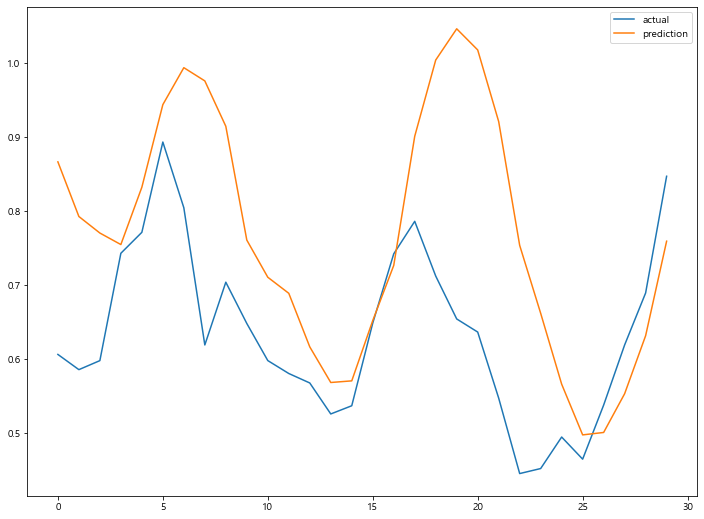

In [69]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

## 상관관계 확인
---

In [70]:
target_i

0       83809
1       70427
2       62652
3       47050
4       30709
        ...  
295    457970
296    525619
297    600890
298    665901
299    811928
Name: IND, Length: 300, dtype: int64

In [71]:
df_check =pd.concat([data,target_c,target_i],axis=1) 

In [72]:
df_check.corr()

,AT,LT,HT,CAP_TEMP_EF,DONGNAM_TEMP_EF,DAEGYUNG_TEMP_EF,CHOONG_TEMP_EF,HONAM_TEMP_EF,MEAN_TEMP_EF,POWER_WATER,...,mining,manufact,ind_sum,QUARTER,Value,RV,GAS_PRICE_IND,OIL_PRICE,CIVIL,IND
AT,1.000000,0.981602,0.976676,-0.793539,-0.831270,-0.829889,-0.838788,-0.821678,-0.817053,0.608421,...,0.294045,0.436839,0.422915,0.243877,0.451481,-0.084196,0.331416,0.312355,-0.654744,0.132147
LT,0.981602,1.000000,0.929466,-0.845730,-0.873102,-0.883641,-0.883771,-0.863138,-0.866450,0.619781,...,0.185704,0.293010,0.277909,0.244628,0.303639,-0.071564,0.227769,0.220581,-0.740967,-0.013992
HT,0.976676,0.929466,1.000000,-0.694848,-0.739788,-0.733968,-0.749481,-0.734818,-0.721156,0.571275,...,0.411430,0.586146,0.574255,0.191824,0.604273,-0.093176,0.444737,0.411548,-0.515668,0.294810
CAP_TEMP_EF,-0.793539,-0.845730,-0.694848,1.000000,0.958148,0.967380,0.977956,0.964464,0.994682,-0.606986,...,0.022608,0.010040,0.023150,-0.271250,0.006740,0.013621,0.020195,0.001928,0.877406,0.287275
DONGNAM_TEMP_EF,-0.831270,-0.873102,-0.739788,0.958148,1.000000,0.985652,0.986853,0.990027,0.980932,-0.601664,...,0.001296,-0.038547,-0.026347,-0.362449,-0.042552,0.027286,-0.016393,-0.029070,0.872404,0.240847
DAEGYUNG_TEMP_EF,-0.829889,-0.883641,-0.733968,0.967380,0.985652,1.000000,0.989388,0.980326,0.984968,-0.617588,...,0.018494,-0.011086,0.002137,-0.268727,-0.010960,0.032731,-0.000142,-0.021794,0.873698,0.275337
CHOONG_TEMP_EF,-0.838788,-0.883771,-0.749481,0.977956,0.986853,0.989388,1.000000,0.994336,0.993418,-0.590145,...,-0.007189,-0.035100,-0.021747,-0.280327,-0.036997,0.021992,-0.004558,-0.020194,0.886714,0.260922
HONAM_TEMP_EF,-0.821678,-0.863138,-0.734818,0.964464,0.990027,0.980326,0.994336,1.000000,0.985222,-0.561499,...,-0.004649,-0.027354,-0.014303,-0.329633,-0.031204,0.027808,-0.000508,-0.016304,0.887378,0.259936
MEAN_TEMP_EF,-0.817053,-0.866450,-0.721156,0.994682,0.980932,0.984968,0.993418,0.985222,1.000000,-0.605077,...,0.012832,-0.007452,0.005711,-0.291263,-0.010461,0.019444,0.008967,-0.008443,0.886776,0.276981
POWER_WATER,0.608421,0.619781,0.571275,-0.606986,-0.601664,-0.617588,-0.590145,-0.561499,-0.605077,1.000000,...,0.150735,0.277135,0.270458,0.177874,0.259486,-0.105141,0.262966,0.272395,-0.420026,0.125716


In [73]:
df_check.corrwith(df_check['CIVIL'], axis = 0 ), df_check.corrwith(df_check['IND'], axis = 0)

# [ 산업용 ]
# -> 최저온도, 기온효과,POWER_FIRE, service, civil_sum

# [ 민간용 ]
# POWER_FIRE           0.930535
# POWER_NUCLEAR        0.714873
# POWER_GAS            0.888670
# POWER_YOU            0.885779
#  all                  0.924607
#  family               0.843233
#  public               0.924640
#  service              0.891098
#  civil_sum            0.893102
#  argri_fishing        0.852336
#  mining               0.732399
#  manufact             0.914618
#  ind_sum              0.916622
#  Value                0.899136
#  GAS                  0.834184
#  OTHER OIL PRODUCT    0.769863

(AT                 -0.654744
 LT                 -0.740967
 HT                 -0.515668
 CAP_TEMP_EF         0.877406
 DONGNAM_TEMP_EF     0.872404
 DAEGYUNG_TEMP_EF    0.873698
 CHOONG_TEMP_EF      0.886714
 HONAM_TEMP_EF       0.887378
 MEAN_TEMP_EF        0.886776
 POWER_WATER        -0.420026
 POWER_FIRE          0.494229
 POWER_NUCLEAR       0.278940
 POWER_NAEYEON       0.159015
 POWER_GROUP         0.344741
 POWER_TRANS         0.201696
 POWER_GAS           0.389385
 POWER_JUNG          0.251030
 POWER_MOO           0.053002
 POWER_YOU           0.334125
 POWER_LNG           0.255683
 all                 0.417276
 family              0.359507
 public              0.493577
 service             0.550681
 civil_sum           0.503671
 argri_fishing       0.450613
 mining              0.282141
 manufact            0.306123
 ind_sum             0.319953
 QUARTER            -0.287390
 Value               0.310369
 RV                 -0.043915
 GAS_PRICE_IND       0.279592
 OIL_PRICE

In [74]:
data1 = data.drop('YEAR',axis=1)
data1

,AT,LT,HT,CAP_TEMP_EF,DONGNAM_TEMP_EF,DAEGYUNG_TEMP_EF,CHOONG_TEMP_EF,HONAM_TEMP_EF,MEAN_TEMP_EF,POWER_WATER,...,civil_sum,argri_fishing,mining,manufact,ind_sum,QUARTER,Value,RV,GAS_PRICE_IND,OIL_PRICE
0,0.004764,-0.189311,0.240528,0.84711,5.91778,6.73765,3.33479,1.88651,3.744768,363291,...,6988059,301811,80421,8854576,9236808,0,36550.3,0.97,26.94,27.86
1,0.007708,-0.226982,0.372691,0.81430,5.90875,6.73291,3.32638,1.87883,3.732234,356379,...,6898533,327617,70471,8067220,8465308,0,36550.3,0.93,26.94,29.04
2,0.137972,-0.045631,0.367739,0.60731,5.81529,6.67634,3.22000,1.78740,3.621268,362980,...,6416945,345359,81877,9250086,9677322,0,36550.3,0.96,26.94,27.99
3,0.261910,0.029456,0.582132,0.24132,5.71003,6.61264,3.07795,1.66054,3.460496,367415,...,6615182,292235,84596,9274014,9650845,1,37152.4,0.94,26.94,28.74
4,0.428759,0.242892,0.688458,-0.38328,5.67433,6.58956,3.02586,1.62083,3.305460,440662,...,6370027,302913,80963,9274169,9658045,1,37152.4,0.92,26.94,29.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.341732,3.072238,3.949415,-0.52038,5.55479,6.50341,2.91789,1.55535,3.202212,1074388,...,22252059,1432700,110871,20803586,22347157,2,121747.5,0.86,72.93,84.71
296,2.623888,2.040712,3.317034,-0.48046,5.62159,6.57738,2.98076,1.59811,3.259476,880238,...,22125819,1535383,124192,21325400,22984975,2,121747.5,0.80,65.24,81.26
297,1.844505,1.092630,2.554311,-0.14824,5.67245,6.61732,3.06704,1.64228,3.370170,473979,...,17725942,1164339,121749,20053280,21339368,3,124740.4,0.76,59.16,78.13
298,1.149119,0.389722,2.114493,0.23138,5.73286,6.65465,3.15240,1.70088,3.494434,424738,...,18720765,1580276,156931,20689055,22426262,3,124740.4,0.75,58.72,78.64


<AxesSubplot:xlabel='YEAR', ylabel='CIVIL'>

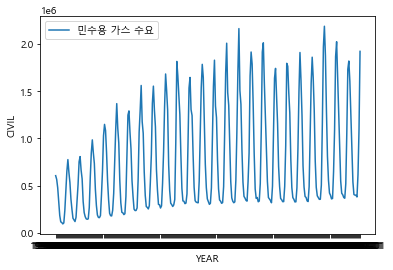

In [75]:
sns.lineplot(y=target['CIVIL'], x=data['YEAR'], label ='민수용 가스 수요')

In [76]:
data_scaled

,AT,LT,HT,CAP_TEMP_EF,DONGNAM_TEMP_EF,DAEGYUNG_TEMP_EF,CHOONG_TEMP_EF,HONAM_TEMP_EF,MEAN_TEMP_EF,POWER_WATER,...,civil_sum,argri_fishing,mining,manufact,ind_sum,Value,RV,GAS,OTHER OIL PRODUCT,QUARTER
0,0.119401,0.211867,0.059217,0.962362,0.843924,0.842862,0.836159,0.803336,0.897574,0.165935,...,0.032655,0.008191,0.089819,0.057683,0.049688,0.000000,0.009127,0.576471,0.000000,0.000000
1,0.120178,0.202764,0.092605,0.944191,0.823706,0.826438,0.819845,0.785243,0.879284,0.159738,...,0.027925,0.024838,0.038433,0.005028,0.002813,0.000000,0.009127,0.529412,0.000000,0.006917
2,0.154554,0.246586,0.091354,0.829553,0.614455,0.630423,0.613482,0.569850,0.717359,0.165656,...,0.002479,0.036284,0.097338,0.084134,0.076453,0.000000,0.009127,0.564706,0.000000,0.000762
3,0.187260,0.264731,0.145515,0.626857,0.378784,0.409702,0.337924,0.270990,0.482756,0.169633,...,0.012953,0.002014,0.111380,0.085734,0.074844,0.333333,0.015879,0.541176,0.000000,0.005159
4,0.231290,0.316306,0.172376,0.280936,0.298854,0.329730,0.236877,0.177441,0.256523,0.235305,...,0.000000,0.008902,0.092618,0.085744,0.075281,0.333333,0.015879,0.517647,0.000000,0.007738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.000000,1.000000,0.996179,0.205006,0.031211,0.031220,0.027430,0.023181,0.105861,0.803492,...,0.839172,0.737714,0.247074,0.856790,0.846251,0.666667,0.964534,0.447059,0.436960,0.333255
296,0.810567,0.750738,0.836423,0.227114,0.180772,0.287526,0.149389,0.123916,0.189422,0.629421,...,0.832501,0.803953,0.315869,0.891687,0.885004,0.666667,0.964534,0.376471,0.363895,0.313031
297,0.604894,0.521640,0.643739,0.411108,0.294644,0.425918,0.316760,0.227973,0.350950,0.265176,...,0.600022,0.564597,0.303253,0.806613,0.785020,1.000000,0.998097,0.329412,0.306128,0.294683
298,0.421387,0.351787,0.532630,0.621352,0.429899,0.555267,0.482347,0.366024,0.532280,0.221027,...,0.652586,0.832913,0.484946,0.849131,0.851057,1.000000,0.998097,0.317647,0.301948,0.297673


In [77]:
df_scaled.corrwith(df_check['CIVIL'], axis = 0 ), df_scaled.corrwith(df_check['IND'], axis = 0)

(AT                 -0.654744
 LT                 -0.740967
 HT                 -0.515668
 CAP_TEMP_EF         0.877406
 DONGNAM_TEMP_EF     0.872404
 DAEGYUNG_TEMP_EF    0.873698
 CHOONG_TEMP_EF      0.886714
 HONAM_TEMP_EF       0.887378
 MEAN_TEMP_EF        0.886776
 POWER_WATER        -0.420026
 POWER_FIRE          0.494229
 POWER_NUCLEAR       0.278940
 POWER_NAEYEON       0.159015
 POWER_GROUP         0.344741
 POWER_TRANS         0.201696
 POWER_GAS           0.389385
 POWER_JUNG          0.251030
 POWER_MOO           0.053002
 POWER_YOU           0.334125
 POWER_LNG           0.255683
 all                 0.417276
 family              0.359507
 public              0.493577
 service             0.550681
 civil_sum           0.503671
 argri_fishing       0.450613
 mining              0.282141
 manufact            0.306123
 ind_sum             0.319953
 QUARTER            -0.287390
 Value               0.310369
 RV                 -0.043915
 GAS_PRICE_IND       0.279592
 OIL_PRICE

In [78]:
df_scaled.columns

Index(['AT', 'LT', 'HT', 'CAP_TEMP_EF', 'DONGNAM_TEMP_EF', 'DAEGYUNG_TEMP_EF',
       'CHOONG_TEMP_EF', 'HONAM_TEMP_EF', 'MEAN_TEMP_EF', 'POWER_WATER',
       'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON', 'POWER_GROUP',
       'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO', 'POWER_YOU',
       'POWER_LNG', 'all', 'family', 'public', 'service', 'civil_sum',
       'argri_fishing', 'mining', 'manufact', 'ind_sum', 'QUARTER', 'Value',
       'RV', 'GAS_PRICE_IND', 'OIL_PRICE', 'CIVIL', 'IND'],
      dtype='object')

In [79]:
target[['CIVIL','IND']]

,CIVIL,IND
0,605519,83809
1,566323,70427
2,477514,62652
3,337797,47050
4,184522,30709
...,...,...
295,398661,457970
296,380235,525619
297,616682,600890
298,1093747,665901


In [80]:
scaler = MinMaxScaler()
df_target = scaler.fit_transform(target[['IND','CIVIL']])
df_target = pd.DataFrame(df_target)
df_target.columns = ['IND','CIVIL']


<AxesSubplot:xlabel='YEAR', ylabel='IND'>

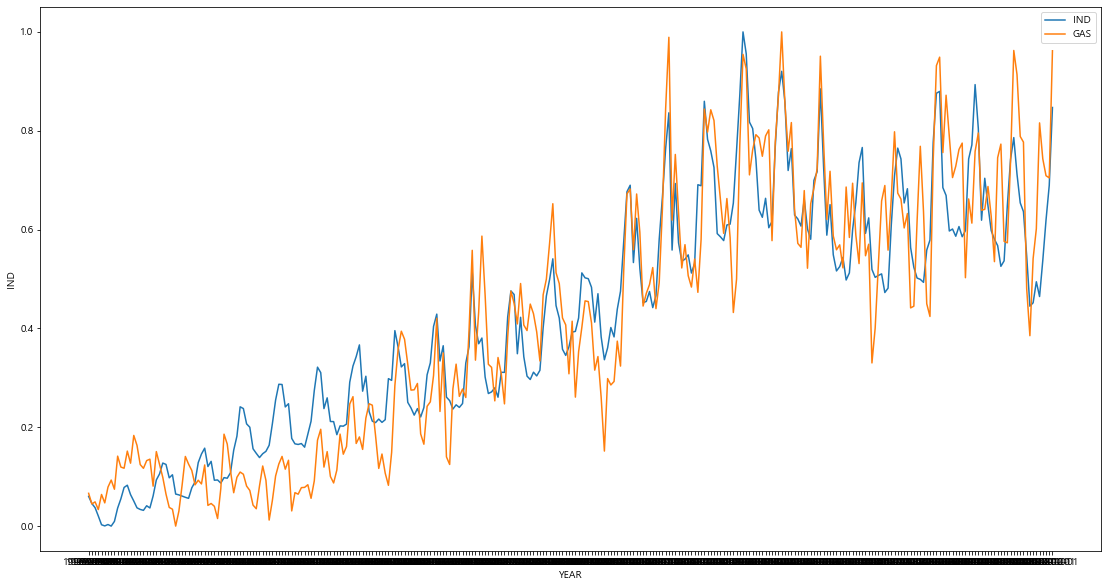

In [87]:
plt.figure(figsize=(19,10))
#sns.lineplot(y=df_target['IND'], x=data['YEAR'],label='IND',color='blue')
sns.lineplot(y=df_target['IND'], x=data['YEAR'],label='IND')
sns.lineplot(y=df_scaled['POWER_FIRE'], x=data['YEAR'],label='GAS')
#sns.lineplot(y=df_scaled['POWER_FIRE'], x=data['YEAR'],label='all',color='orange')
#sns.lineplot(y=df_scaled['POWER_FIRE'], x=data['YEAR'],label='fire',color='orange')
#sns.lineplot(y=df_scaled['service'], x=data['YEAR'],label='SERVICE')


<AxesSubplot:xlabel='YEAR', ylabel='IND'>

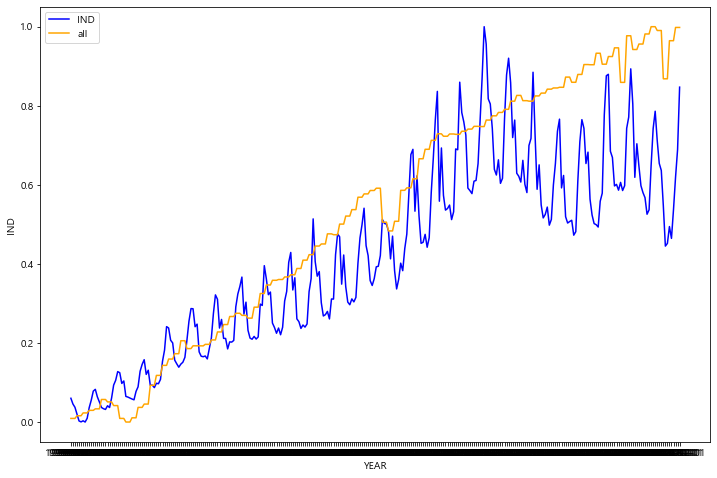

In [57]:
plt.figure(figsize=(12,8))
sns.lineplot(y=df_target['IND'], x=data['YEAR'],label='IND',color='blue')
#sns.lineplot(y=df_target['CIVIL'], x=data['YEAR'],label='CIVIL')
#sns.lineplot(y=df_scaled['LT'], x=data['YEAR'],label='LT')
sns.lineplot(y=df_scaled['Value'], x=data['YEAR'],label='all',color='orange')
#sns.lineplot(y=df_scaled['POWER_FIRE'], x=data['YEAR'],label='fire',color='orange')
#sns.lineplot(y=df_scaled['service'], x=data['YEAR'],label='SERVICE')
